# Need to run automatic lfilter as pbs job

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
import numpy as np
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.cm.get_cmap("gist_earth")
from datetime import timedelta
import filtering
import numpy as np
import dask
from dask.distributed import Client,default_client


client = tt.startdask()


/jobfs/114787454.gadi-pbs/ipykernel_922137/1885188760.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  earth_cmap = matplotlib.cm.get_cmap("gist_earth")
sh: None: command not found
INFO: Compiled ParcelsRandom ==> /jobfs/114787454.gadi-pbs/parcels-16078/libparcels_random_59acbe70-ad53-4ca4-9886-927258795cd4.so


<Client: 'tcp://127.0.0.1:45463' processes=7 threads=28, memory=112.00 GiB>


## Make a more comprehensive lfilter

Already have a working lagrange filter script that does a 16hr cutoff and outputs the cross scale transfer. What I want though is in a single command to:
 - Calculate the $M2+ \delta$ & $M2 - \delta$ fields for UU,VV,UV,U,V as normal 
 - Use the difference to get corresponding bandpassed fields $u_{m2} = u - u_+ - u_-$
 - Save csf terms, bandpass dissipation, bandpass KE all together in one dataset. 
 - Later can calculate the barotropic signal! 

In [5]:
m2 = 360 / 28.984104

print(m2 * (1 + 0.4 / 1.9))
print(m2 * (1 - 0.4 / 1.9))

15.03546473902421
9.805737873276659


In [53]:
## Original lagrange filter script to modify

def NewLfilter(expt,zl,t0,time_window = 250,filter_window = 200):
    print("START LAGRANGE FILTERING")
    print("import filtering package:")
    import filtering

    """
    Apply the Lagrange filter to the input data. This is a wrapper around the LagrangeFilter class in filtering.py
    Saves the outputs to `postprocessing/expt/lfiltered/t0-<t0>/filtered_<zl>.nc` with a separate file for each z level.
    Inputs:
        expt: str, the experiment to process
        zl: int, the z level(s) to process
        t0: int, the middle time of the time slice we care about
    """
    HighFilterCutoff = 2*np.pi/(16*3600)  ## Same as tolerences for bandpass in Waterhouse 2018
    LowFilterCutoff = 2*np.pi/(10.4*3600)

    client = tt.startdask()
    dask.config.set(scheduler="single-threaded")
    tmpstorage = os.getenv('PBS_JOBFS')

    rawdata = tt.collect_data(
        expt,
        rawdata = ["u","v","ahh"],
        timerange=(t0 - time_window,t0 + time_window)).isel(zl = [zl])

    # Save attributes to re-add later
    attrs = {
        "u": rawdata.u.attrs,
        "v": rawdata.v.attrs,
        "time": rawdata.time.attrs,
        "xb": rawdata.xb.attrs,
        "yb": rawdata.yb.attrs,
        "zl": rawdata.zl.attrs,
        "base" : rawdata.attrs
    }

    ## Save z level to re-add later
    zl_value = rawdata.zl.values[0]

    ## Remove zl to make data properly 2D
    _rawdata = rawdata.isel(zl = 0) # Make a copy to modify the metadata to keep lagrange filter happy
    # We'll keep rawdata for use later.

    # Strip attrs since lagrange filter complains about them
    _rawdata.u.attrs = {}
    _rawdata.v.attrs = {}
    _rawdata.zl.attrs = {}
    _rawdata.time.attrs = {}
    _rawdata.yb.attrs = {}
    _rawdata.xb.attrs = {}
    _rawdata = _rawdata.assign_coords({
        "time":_rawdata.time * 3600,
        "xb":_rawdata.xb * 1000,
        "yb":_rawdata.yb * 1000})
    _rawdata = _rawdata.drop_vars(["bathy","lat","lon"]) 

    print("Saving data to temporary storage")
    _rawdata.u.to_netcdf(tmpstorage + f"/u.nc",mode="w")
    _rawdata.v.to_netcdf(tmpstorage + f"/v.nc",mode="w")
    (_rawdata.v**2).rename("vv").to_netcdf(tmpstorage + f"/vv.nc",mode="w")
    (_rawdata.u**2).rename("uu").to_netcdf(tmpstorage + f"/uu.nc",mode="w")
    (_rawdata.u*_rawdata.v).rename("uv").to_netcdf(tmpstorage + f"/uv.nc",mode="w")
    print("done")
    client.close() ## Have to close dask client or it messes up the filtering package

    f_high = filtering.LagrangeFilter(
        tmpstorage + "/lowpass", ## Save intermediate output to temporary storage
        {
            "U":tmpstorage + "/u.nc",
            "V":tmpstorage + "/v.nc",
            "uu":tmpstorage + "/uu.nc",
            "vv":tmpstorage + "/vv.nc",
            "uv":tmpstorage + "/uv.nc"
        }, 
        {"U":"u","V":"v","uu":"uu","vv":"vv","uv":"uv"}, 
        {"lon":"xb","lat":"yb","time":"time"},
        sample_variables=["U","V","vv","uu","uv"], mesh="flat",highpass_frequency = HighFilterCutoff,
        advection_dt =timedelta(minutes=5).total_seconds(),
        window_size = timedelta(hours=48).total_seconds(),
    )
    f_low = filtering.LagrangeFilter(
        tmpstorage + "/highpass", ## Save intermediate output to temporary storage
        {
            "U":tmpstorage + "/u.nc",
            "V":tmpstorage + "/v.nc",
            "uu":tmpstorage + "/uu.nc",
            "vv":tmpstorage + "/vv.nc",
            "uv":tmpstorage + "/uv.nc"
        }, 
        {"U":"u","V":"v","uu":"uu","vv":"vv","uv":"uv"}, 
        {"lon":"xb","lat":"yb","time":"time"},
        sample_variables=["U","V","vv","uu","uv"], mesh="flat",highpass_frequency = LowFilterCutoff,
        advection_dt =timedelta(minutes=5).total_seconds(),
        window_size = timedelta(hours=48).total_seconds()
    )
    print("lowpass filter")
    ## Ensure we take times either side of the point of interest
    f_low(times = range(3600 * (time_window - filter_window),3600 * (time_window + filter_window),3600)) 
    print("Highpass filter")
    f_high(times = range(3600 * (time_window - filter_window),3600 * (time_window + filter_window),3600)) ## Ensure we take 

    

    ## Remove stored data to save space on disk
    for i in ["u","v","uu","vv","uv"]:
        os.remove(tmpstorage + f"/{i}.nc")

    client = tt.startdask()
    print(os.listdir(tmpstorage))
    ## Load the filtered data
    highpass = xr.open_dataset(tmpstorage + "/highpass.nc",chunks = "auto")
    lowpass = xr.open_dataset(tmpstorage + "/lowpass.nc",chunks = "auto")


    def tidyup(filtered):
        """Necessary tidying up of metadata and units for filtered outputs"""
    ## Re-add zl as a dimension. Expand dims, then add zl
        filtered = filtered.expand_dims({"zl":[zl_value]})

        ## Restore scale and attributes of rawdata
        filtered = filtered.assign_coords({
            "time":filtered.time / 3600,
            "xb":filtered.xb / 1000,
            "yb":filtered.yb / 1000})

        ## Fix up names of filtered variables:
        for i in filtered.data_vars:
            filtered = filtered.rename({i:i.split("_")[1].lower()})

        filtered.attrs = attrs["base"]
        filtered.u.attrs = attrs["u"]
        filtered.v.attrs = attrs["v"]
        filtered.zl.attrs = attrs["zl"]
        filtered.time.attrs = attrs["time"]
        filtered.yb.attrs = attrs["yb"]
        filtered.xb.attrs = attrs["xb"]

        filtered.attrs["long_name"] = "Filtered velocity data"
        return filtered

    highpass = tidyup(highpass)
    lowpass = tidyup(lowpass)
    outfolder = Path(f"/g/data/nm03/ab8992/postprocessed/{expt}/lfiltered/t0-{t0}")

    if not os.path.exists(outfolder):
        os.makedirs(outfolder)
    highpass["cst"] = tt.cross_scale_transfer(highpass)
    lowpass["cst"] = tt.cross_scale_transfer(lowpass) 
    highpass[["u","v","cst"]].to_netcdf(outfolder / f"highpass_{zl}.nc",mode="w")
    lowpass[["u","v","cst"]].to_netcdf(outfolder / f"highpass_{zl}.nc",mode="w")
    return 



START LAGRANGE FILTERING
import filtering package:


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34647 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:40571' processes=7 threads=28, memory=112.00 GiB>
loading u...	

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/base.py:1444: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


done.
loading v...	

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/base.py:1444: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


done.
loading ahh...	

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/base.py:1444: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


done.
Saving data to temporary storage


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/base.py:1444: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/base.py:1444: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/base.py:1444: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/base.py:1444: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


done


sh: None: command not found
INFO: Compiled SamplingParticlesample_kernel ==> /jobfs/114787454.gadi-pbs/parcels-16078/b2c9c94868ebf162f4fbb31ee4ae3859_0.so
INFO:parcels.tools.loggers:Compiled SamplingParticlesample_kernel ==> /jobfs/114787454.gadi-pbs/parcels-16078/b2c9c94868ebf162f4fbb31ee4ae3859_0.so
sh: None: command not found
INFO: Compiled SamplingParticleAdvectionRK4sample_kernel ==> /jobfs/114787454.gadi-pbs/parcels-16078/1dbf98f688f8f5156a2423cb31ae4d2b_0.so
INFO:parcels.tools.loggers:Compiled SamplingParticleAdvectionRK4sample_kernel ==> /jobfs/114787454.gadi-pbs/parcels-16078/1dbf98f688f8f5156a2423cb31ae4d2b_0.so
sh: None: command not found
INFO: Compiled SamplingParticlesample_kernel ==> /jobfs/114787454.gadi-pbs/parcels-16078/1df4c82f03997512ed9b2f1c642a6fef_0.so
INFO:parcels.tools.loggers:Compiled SamplingParticlesample_kernel ==> /jobfs/114787454.gadi-pbs/parcels-16078/1df4c82f03997512ed9b2f1c642a6fef_0.so
sh: None: command not found
INFO: Compiled SamplingParticleAdvectio

lowpass filter


INFO: Temporary output files are stored in /home/149/ab8992/tmp26nvbvai.h5.
INFO:parcels.tools.loggers:Temporary output files are stored in /home/149/ab8992/tmp26nvbvai.h5.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/149/ab8992/tmp26nvbvai.h5" to convert these to a NetCDF file during the run.
INFO:parcels.tools.loggers:You can use "parcels_convert_npydir_to_netcdf /home/149/ab8992/tmp26nvbvai.h5" to convert these to a NetCDF file during the run.
100% (172800.0 of 172800.0) |############| Elapsed Time: 0:00:04 Time:  0:00:04
INFO: Temporary output files are stored in /home/149/ab8992/tmp26nvbvai.h5.
INFO:parcels.tools.loggers:Temporary output files are stored in /home/149/ab8992/tmp26nvbvai.h5.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/149/ab8992/tmp26nvbvai.h5" to convert these to a NetCDF file during the run.
INFO:parcels.tools.loggers:You can use "parcels_convert_npydir_to_netcdf /home/149/ab8992/tmp26nvbvai.h5" to convert these to a NetCDF file during t

Highpass filter


INFO: Temporary output files are stored in /home/149/ab8992/tmpm_n3zjmr.h5.
INFO:parcels.tools.loggers:Temporary output files are stored in /home/149/ab8992/tmpm_n3zjmr.h5.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/149/ab8992/tmpm_n3zjmr.h5" to convert these to a NetCDF file during the run.
INFO:parcels.tools.loggers:You can use "parcels_convert_npydir_to_netcdf /home/149/ab8992/tmpm_n3zjmr.h5" to convert these to a NetCDF file during the run.
100% (172800.0 of 172800.0) |############| Elapsed Time: 0:00:06 Time:  0:00:06
INFO: Temporary output files are stored in /home/149/ab8992/tmpm_n3zjmr.h5.
INFO:parcels.tools.loggers:Temporary output files are stored in /home/149/ab8992/tmpm_n3zjmr.h5.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/149/ab8992/tmpm_n3zjmr.h5" to convert these to a NetCDF file during the run.
INFO:parcels.tools.loggers:You can use "parcels_convert_npydir_to_netcdf /home/149/ab8992/tmpm_n3zjmr.h5" to convert these to a NetCDF file during t

<Client: 'tcp://127.0.0.1:35395' processes=7 threads=28, memory=112.00 GiB>
['ompi.gadi-cpu-bdw-0016.16078', 'parcels-16078', 'dask-scratch-space', 'highpass.nc', 'lowpass.nc']


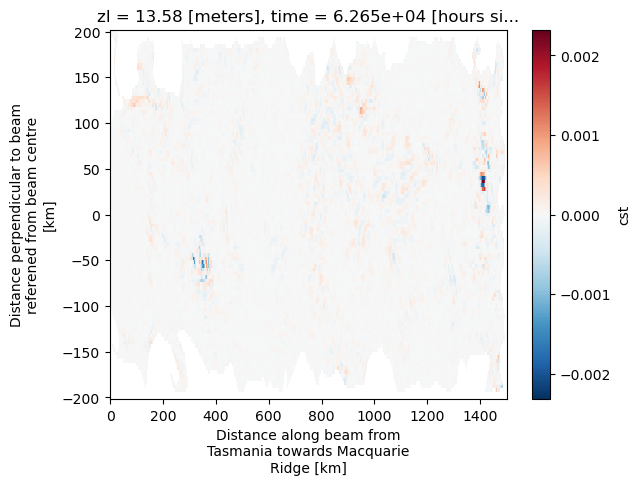

In [57]:
highpass.cst.isel(time = 0,zl = 0).plot()

In [27]:
t0,time_window,zl = 62655,4,2

rawdata = tt.collect_data(
    'full-20',
    rawdata = ["u","v","ahh"],
    timerange=(t0 - time_window,t0 + time_window)).isel(zl = [zl])

tmp = os.getenv('PBS_JOBFS')

highpass = xr.open_dataset(tmp + "/highpass.nc",decode_times= False)
lowpass = xr.open_dataset(tmp + "/filtered.nc",decode_times = False)

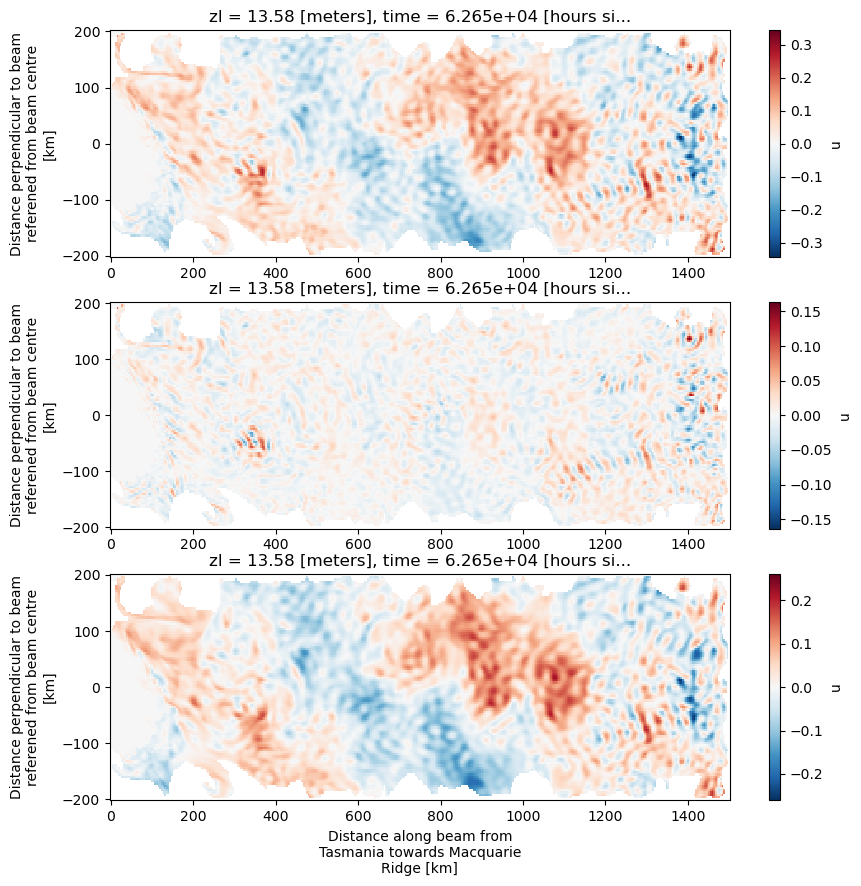

In [62]:
fig,ax = plt.subplots(3,figsize = (10,10))
lowpass.isel(time = 0).u.plot(ax = ax[0])
highpass.isel(time = 0).u.plot(ax = ax[1])
(lowpass - highpass).u.isel(time = 0).plot(ax = ax[2])
for i in range(2):
    ax[i].set_xlabel("")
# rawdata.isel(time = 0).u.plot(ax = ax[2])
# (rawdata.u).isel(time = 0).plot(ax = ax[2])


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'Dissipation')

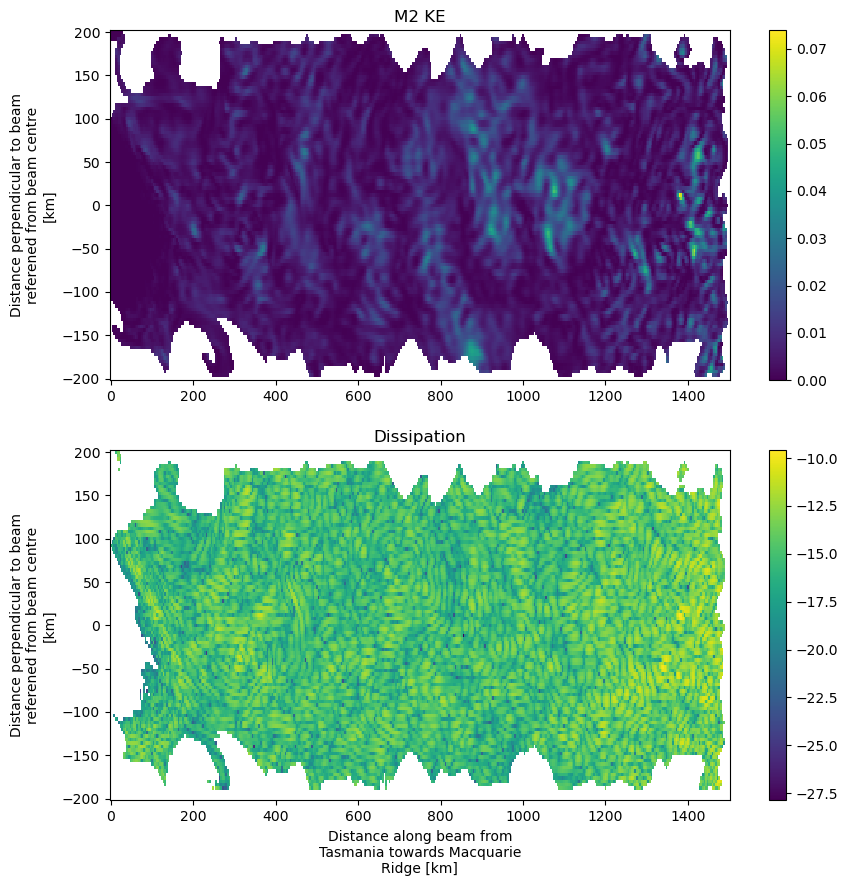

In [81]:
fig,ax = plt.subplots(2,figsize = (10,10))

UU_bp,VV_bp = (highpass.u - lowpass.u)**2,(highpass.v - lowpass.v)**2
U_bp,V_bp = (highpass.u - lowpass.u),(highpass.v - lowpass.v)
(UU_bp + VV_bp).isel(time = 0).plot(ax = ax[0])
ax[0].set_title("M2 KE")
ax[0].set_xlabel("")

laplacian2 = (U_bp.differentiate("xb").differentiate("xb") + V_bp.differentiate("yb").differentiate("yb"))**2
# dissipation = (laplacian2.mean("time").isel(zl = 0) * rawdata.ahh.mean("time").isel(zl = 0))
dissipation = (laplacian2.isel(zl = 0) * 1).mean("time")
np.log(dissipation).plot(ax = ax[1])
ax[1].set_title("Dissipation")

In [1]:
from pathlib import Path



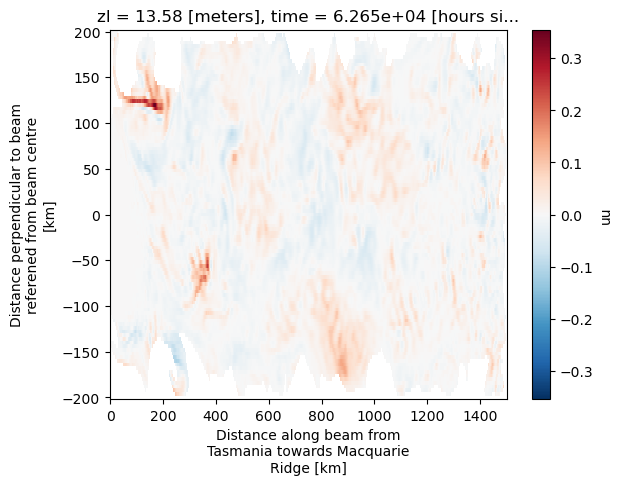

In [72]:
lowpass.uu.isel(zl = 0,time = 0).plot()

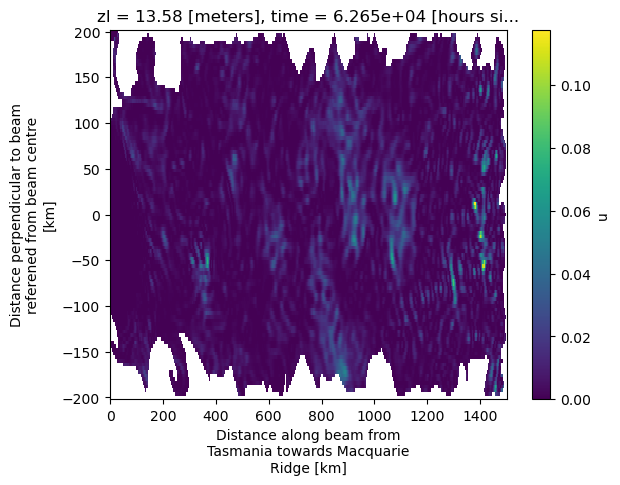

In [73]:
(lowpass.u**2).isel(zl = 0,time = 0).plot()


In [46]:
laplacian2 = (UU_bp.differentiate("xb").differentiate("xb") + VV_bp.differentiate("yb").differentiate("yb"))

dissipation = (laplacian2.mean("time") * rawdata.ahh.mean("time").isel(zl = 0))


<xarray.DataArray (yb: 101, xb: 376)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * yb       (yb) float64 -2e+05 -1.96e+05 -1.92e+05 ... 1.92e+05 1.96e+05 2e+05
  * xb       (xb) float64 -0.0 4e+03 8e+03 ... 1.492e+06 1.496e+06 1.5e+06

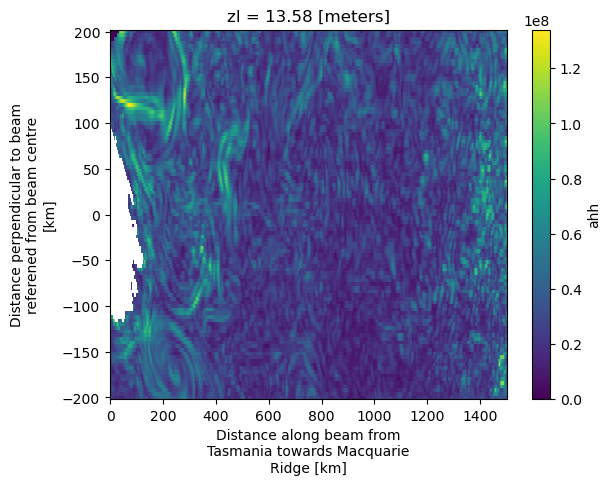

In [48]:
rawdata.ahh.mean("time").isel(zl = 0).plot()

In [41]:
rawdata.ahh

<xarray.DataArray 'ahh' (time: 9, zl: 1, yb: 101, xb: 376)>
dask.array<getitem, shape=(9, 1, 101, 376), dtype=float32, chunksize=(9, 1, 6, 376), chunktype=numpy.ndarray>
Coordinates:
  * zl       (zl) float64 13.58
  * time     (time) float64 6.265e+04 6.265e+04 ... 6.266e+04 6.266e+04
  * xb       (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 -200.0 -196.0 -192.0 -188.0 ... 192.0 196.0 200.0
    lon      (yb, xb) float64 dask.array<chunksize=(101, 376), meta=np.ndarray>
    lat      (yb, xb) float64 dask.array<chunksize=(101, 376), meta=np.ndarray>
Attributes:
    _FillValue:    nan
    units:         m4 s-1
    long_name:     Biharmonic Horizontal Viscosity at h Points
    cell_methods:  area:mean z_l:mean yh:mean xh:mean time: point
    Description:   Beamwidth 400km, Beamlength 1500km, Resolution 4.0km, angl...
    coordinates:   lat lon